In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models

def preprocess_image(path, target_size=96):
    import cv2
    import numpy as np

    # ƒê·ªçc ·∫£nh ·ªü d·∫°ng grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # B∆∞·ªõc 1: Resize v·ªÅ 256x256
    img_256 = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

    # B∆∞·ªõc 2: Ti·∫øp t·ª•c resize v·ªÅ k√≠ch th∆∞·ªõc mong mu·ªën (target_size x target_size)
    resized = cv2.resize(img_256, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # Chu·∫©n h√≥a pixel v·ªÅ [0, 1]
    normalized = resized.astype('float32') / 255.0

    # Th√™m channel dimension: (target_size, target_size, 1)
    normalized = normalized.reshape(target_size, target_size, 1)

    # Th√™m batch dimension: (1, target_size, target_size, 1)
    return np.expand_dims(normalized, axis=0)


In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, target_size=96):
        self.data = []
        for path, label in zip(image_paths, labels):
            img = preprocess_image(path, target_size)
            if img is not None:
                self.data.append((img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).squeeze(0)
        return img_tensor, label


In [3]:
def load_image_paths_and_labels(root_dir):
    import os
    image_paths, labels = [], []
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        if not os.path.isdir(label_path):
            continue
        for filename in os.listdir(label_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(label_path, filename))
                labels.append(int(label))
    return image_paths, labels


In [4]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train loss: {total_loss / len(loader):.4f}")

def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"Test loss: {total_loss / len(loader):.4f} - Accuracy: {acc:.2f}%")


In [5]:
def predict_digits_from_folder(model, input_folder, output_csv, device='cpu', target_size=96):
    import os
    import pandas as pd

    model.eval()
    results = []
    for filename in sorted(os.listdir(input_folder)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(input_folder, filename)
        img = preprocess_image(path, target_size)
        if img is None:
            print(f"‚ö†Ô∏è B·ªè qua ·∫£nh l·ªói: {filename}")
            continue
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
        results.append([filename, pred])
    pd.DataFrame(results, columns=["filename", "predicted_label"]).to_csv(output_csv, index=False)
    print(f"‚úÖ Ghi k·∫øt qu·∫£ v√†o: {output_csv}")


In [6]:
def get_model(device):
    from torchvision import models
    import torch.nn as nn

    mobilenet = models.mobilenet_v2(weights=True)
    mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, 10)
    return mobilenet.to(device)


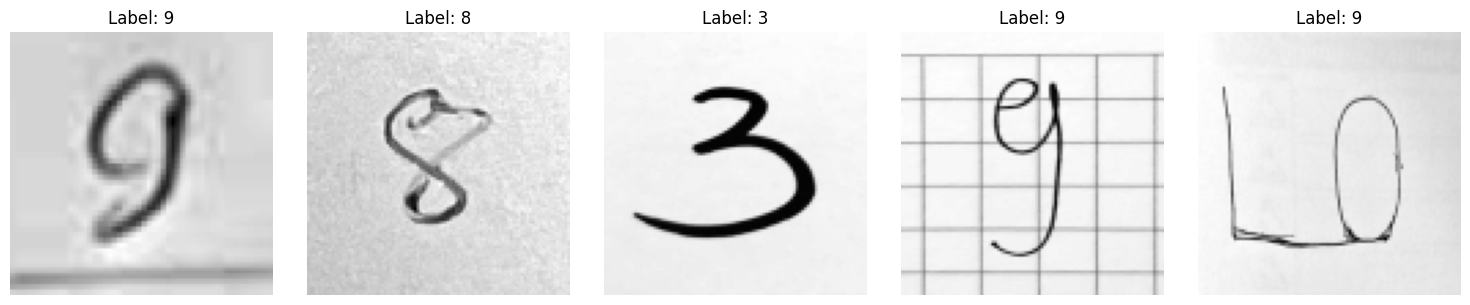

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
Train loss: 1.0844
Test loss: 0.5471 - Accuracy: 84.78%
Epoch 2
Train loss: 0.4791
Test loss: 0.3467 - Accuracy: 90.13%
Epoch 3
Train loss: 0.3681
Test loss: 0.4437 - Accuracy: 87.68%
Epoch 4
Train loss: 0.3039
Test loss: 0.2985 - Accuracy: 91.17%
Epoch 5
Train loss: 0.2334
Test loss: 0.3958 - Accuracy: 88.64%
Epoch 6
Train loss: 0.2278
Test loss: 0.3036 - Accuracy: 92.35%
Epoch 7
Train loss: 0.1850
Test loss: 0.3905 - Accuracy: 88.86%
Epoch 8
Train loss: 0.1801
Test loss: 0.2344 - Accuracy: 94.28%
Epoch 9
Train loss: 0.1349
Test loss: 0.3458 - Accuracy: 92.58%
Epoch 10
Train loss: 0.1607
Test loss: 0.2595 - Accuracy: 93.24%
Epoch 11
Train loss: 0.1437
Test loss: 0.2549 - Accuracy: 92.50%
Epoch 12
Train loss: 0.1277
Test loss: 0.2459 - Accuracy: 94.06%
Epoch 13
Train loss: 0.1222
Test loss: 0.2183 - Accuracy: 93.54%
Epoch 14
Train loss: 0.1126
Test loss: 0.3544 - Accuracy: 91.17%
Epoch 15
Train loss: 0.1001
Test loss: 0.2800 - Accuracy: 93.10%
Epoch 16
Train loss: 0.1169
Test l

In [7]:
# ƒê∆∞·ªùng d·∫´n
root_dir = r"C:\Users\ADMIN\Desktop\ML\sort_images\sort_images"
INPUT_FOLDER = r"C:\Users\ADMIN\Desktop\ML\data.2025"
OUTPUT_CSV = r"C:\Users\ADMIN\Desktop\ML\sub_mobilenet.csv"

# T·∫£i d·ªØ li·ªáu
x_data, y_data = load_image_paths_and_labels(root_dir)

# Chia t·∫≠p
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=42)

# T·∫°o dataset v√† loader
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
#show ·∫£nh 
import matplotlib.pyplot as plt

def show_first_n_images(dataset, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img_tensor, label = dataset[i]  # L·∫•y ·∫£nh v√† nh√£n
        img_np = img_tensor.squeeze().numpy()  # Lo·∫°i b·ªè chi·ªÅu k√™nh v√† chuy·ªÉn v·ªÅ NumPy

        plt.subplot(1, n, i+1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# G·ªçi h√†m ƒë·ªÉ hi·ªÉn th·ªã 5 ·∫£nh ƒë·∫ßu ti√™n
show_first_n_images(train_dataset, n=5)

# T·∫°o model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(device)

# Loss v√† optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hu·∫•n luy·ªán
for epoch in range(1, 21):
    print(f"Epoch {epoch}")
    train(model, train_loader, criterion, optimizer, device)
    test(model, test_loader, criterion, device)

# D·ª± ƒëo√°n folder m·ªõi
predict_digits_from_folder(model, INPUT_FOLDER, OUTPUT_CSV, device)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def evaluate_and_plot_confusion_matrix(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ƒê·ªô ch√≠nh x√°c t·ªïng th·ªÉ
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n‚úÖ Accuracy on test set: {acc * 100:.2f}%")

    # Ma tr·∫≠n nh·∫ßm l·∫´n
    cm = confusion_matrix(all_labels, all_preds)

    # In ch√≠nh x√°c t·ª´ng l·ªõp
    print("\nüéØ Accuracy per class:")
    for i in range(len(cm)):
        correct = cm[i][i]
        total = cm[i].sum()
        class_acc = correct / total if total > 0 else 0
        label_name = class_names[i] if class_names else str(i)
        print(f"  - {label_name}: {class_acc * 100:.2f}% ({correct}/{total})")

    # V·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()




‚úÖ Accuracy on test set: 90.57%

üéØ Accuracy per class:
  - 0: 95.42% (125/131)
  - 1: 93.38% (127/136)
  - 2: 94.07% (127/135)
  - 3: 97.04% (131/135)
  - 4: 83.70% (113/135)
  - 5: 90.30% (121/134)
  - 6: 97.74% (130/133)
  - 7: 91.97% (126/137)
  - 8: 83.70% (113/135)
  - 9: 78.68% (107/136)


<Figure size 800x600 with 0 Axes>

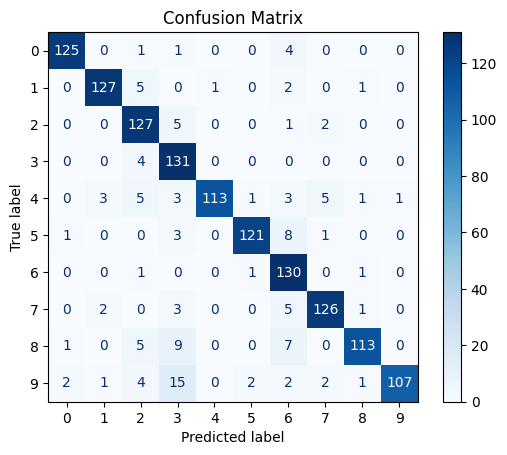

In [11]:
evaluate_and_plot_confusion_matrix(model, test_loader, device, class_names=[str(i) for i in range(10)])


In [ ]:
# d·ª±a v√†o ƒë·ªô ch√≠nh x√°c qua c√°c epoch ta th·∫•y ƒë·ªô ch√≠nh x√°c c·ªßa m√¥ h√¨nh r√¥i v√†o kho·∫£ng 85% (t·ªët h∆°n cnn)
# c√°c s·ªë c√≥ ƒë·ªô ch√≠nh x√°c cao nh∆∞ l√† 0,3,6
# c√°c s·ªë c√≥ ƒë·ªô ch√≠nh x√°c th·∫•p nh∆∞ l√† 7,4,8
# v·ªÅ ma tr·∫≠n nh·∫ßm l·∫´n th√¨ h·∫ßu nh∆∞ ƒë∆∞·ªùng ch√©o ch√≠nh chi·∫øm ∆∞u th·∫ø so v·ªõi c√°c √¥ c√≤n l·∫°i 
# Tuy c√°c s·ªë d·ª± ƒëo√°n v√£n c√≤n x·∫£y ra t√¨nh tr·∫°ng nh·∫ßm l·∫´n nhau nh∆∞ng nh√¨n chung ph·∫ßn nh·∫•m l·∫´n kh√¥ng qu√° 10 ch·ªØ s·ªë cho th·∫•y m√¥ h√¨nh ƒë√£ c√≥ c·∫£i thi·ªán h∆°n 
# r·∫•t nhi·ªÅu so v·ªõi cnn nh∆∞ng t·ªâ l·ªá ch√≠nh x√°c gi≈©a c√°c l·ªõp v·∫´n c√≤n ch√™nh l·ªách h∆°i nhi·ªÅu l·ªõp 9 (78%) , l·ªõp 6 97,74%) 
# B√™n c·∫°nh ƒë√≥ vi·ªác xu·∫•t hi·ªán th√™m c√°c √¥ s·ªë 0 trong ma tr·∫≠n nh·∫ßm l·∫´n cho th·∫•y ƒë·ªô ch√≠nh x√°c c·ªßa b√†i to√°n ƒë√£ ƒë∆∞·ª£c c·∫£i thi·ªán r·∫•t nhi·ªÅu 